## NLP Tutorial

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this tutorial we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

## Import necessary modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS  #Be VERY CAREFUL, it is "WordCloud" and not "wordcloud" after the import functioin
import re

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

### A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

And one that is:

In [5]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

### Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

Note: a `vector` is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.

In [6]:
# Create a duplicate dataframe
hope = train_df.copy()

In [7]:
hope.shape

(7613, 5)

### REMOVE HYPERLINKS

In [8]:
# How many rows contain hyperlinks
hope['text'].str.contains('http?').sum()

3972

In [9]:
#Remove hyperlinks
def remove_http(review):
    url_pattern = re.compile(r'href|http\S+')
    return url_pattern.sub(r'', review)

In [10]:
hope['text'] = hope['text'].apply(remove_http)

In [11]:
# How many rows contain hyperlinks
hope['text'].str.contains('http?').sum()

2

## POPULAR WORDS

In [12]:
#Create a single variable with all the summaries so as to make the removal of STOPWORDS faster
total_text = (' '.join(hope['text']))

total_text[0:1000]

"Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all Forest fire near La Ronge Sask. Canada All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 13,000 people receive #wildfires evacuation orders in California  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas I'm on top of the hill and I can see a fire in the woods... There's an emergency evacuation happening now in the building across the street I'm afraid that the tornado is coming to our area... Three people died from the heat wave so far Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding #raining #flooding #Florida

In [13]:
#substitute every symbol(!"\'.) except(^) a-z with space in the variable "total_text"
total_text = re.sub('[^a-zA-Z]', ' ', total_text)

total_text[0:1000]

'Our Deeds are the Reason of this  earthquake May ALLAH Forgive us all Forest fire near La Ronge Sask  Canada All residents asked to  shelter in place  are being notified by officers  No other evacuation or shelter in place orders are expected        people receive  wildfires evacuation orders in California  Just got sent this photo from Ruby  Alaska as smoke from  wildfires pours into a school   RockyFire Update    California Hwy     closed in both directions due to Lake County fire    CAfire  wildfires  flood  disaster Heavy rain causes flash flooding of streets in Manitou  Colorado Springs areas I m on top of the hill and I can see a fire in the woods    There s an emergency evacuation happening now in the building across the street I m afraid that the tornado is coming to our area    Three people died from the heat wave so far Haha South Tampa is getting flooded hah  WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK  flooding  raining  flooding  Florida

In [14]:
#Remove excess spacing
total_text = re.sub(' +', ' ', total_text)

total_text[0:1000]

'Our Deeds are the Reason of this earthquake May ALLAH Forgive us all Forest fire near La Ronge Sask Canada All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected people receive wildfires evacuation orders in California Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school RockyFire Update California Hwy closed in both directions due to Lake County fire CAfire wildfires flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas I m on top of the hill and I can see a fire in the woods There s an emergency evacuation happening now in the building across the street I m afraid that the tornado is coming to our area Three people died from the heat wave so far Haha South Tampa is getting flooded hah WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK flooding raining flooding Florida TampaBay Tampa or days I ve lost count Flo

## REMOVE STOPWORDS

In [15]:
# Set your stopwords
stop_words2 = set(STOPWORDS)

# Set your second set of stopwords
stop_words = set(stopwords.words('english'))

(-0.5, 999.5, 499.5, -0.5)

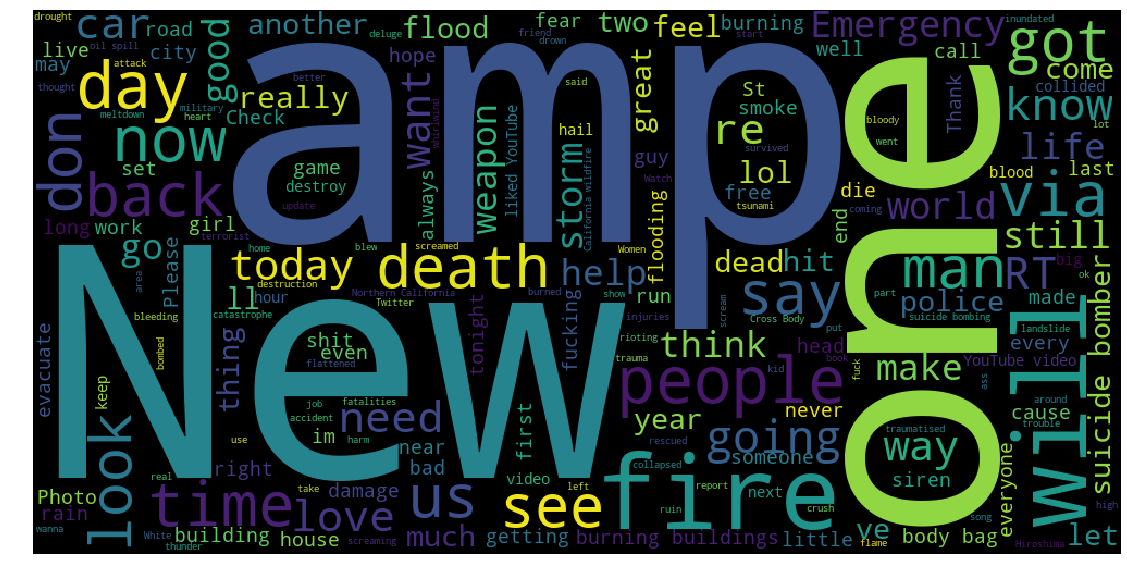

In [16]:
### Find popular words i.e words that occur regularly in hope['text']

wordcloud = WordCloud(width=1000, height=500, stopwords=stop_words2).generate(total_text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off') #to remove the axis number from showing

In [17]:
# Tokenize each sentence in the list sense
word_tokens = word_tokenize(total_text)

In [18]:
word_tokens[0:10]

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 'earthquake',
 'May',
 'ALLAH']

In [19]:
# Create a list(hello) that contains stopwords and a list(filtered_sentence) that contains words without stopwords
filtered_sentence = []
hello = ['amp','don','re','via','st']
for w in word_tokens:
    if w in stop_words2:
        hello.append(w)
    else:
        filtered_sentence.append(w)

In [20]:
# Create an index for the dictionary you will be creating later on
bark = []
for i in range(len(filtered_sentence)):
    bark.append(i)
len(bark)

78646

In [21]:
# Create a dataframe
data = {"id": bark,
        "filtered_sentence": filtered_sentence}
  
df = pd.DataFrame(data)
df

,id,filtered_sentence
0,0,Our
1,1,Deeds
2,2,Reason
3,3,earthquake
4,4,May
...,...,...
78641,78641,Northern
78642,78642,California
78643,78643,Wildfire
78644,78644,ABC


In [22]:
# Create a dataframe that shows the count of each unique word
word_count = df['filtered_sentence'].value_counts(ascending=False)
word_count[1:20]

s         892
The       592
t         496
amp       344
A         338
m         269
will      214
via       213
fire      177
people    167
re        163
In        161
one       160
It        149
don       147
now       144
S         124
News      123
You       121
Name: filtered_sentence, dtype: int64

In [23]:
# Create a list of the dictionary keys
key_list = list(word_count.keys())

In [24]:
# A list of lowercase alphabets + a list of higher alphabets + a list of words in stop_words2
stop_words3 = list(map(chr, range(97, 123))) + list(map(chr, range(65, 90))) + hello
stop_words3[100:110]

['the', 'so', 'is', 'or', 'in', 'to', 'on', 'in', 'up', 'is']

In [25]:
#Remove redundadnt words that are not important
for i in key_list:
    if word_count[i] > 184:
        stop_words3.append(i)
        word_count.pop(i)
    elif word_count[i] < 5:
        word_count.pop(i)  

In [26]:
key_list2 = list(word_count.keys())
key_list2[1:20]

['people',
 're',
 'In',
 'one',
 'It',
 'don',
 'now',
 'S',
 'News',
 'You',
 'California',
 'We',
 'got',
 'RT',
 'This',
 'To',
 'new',
 'disaster',
 'New']

(-0.5, 999.5, 499.5, -0.5)

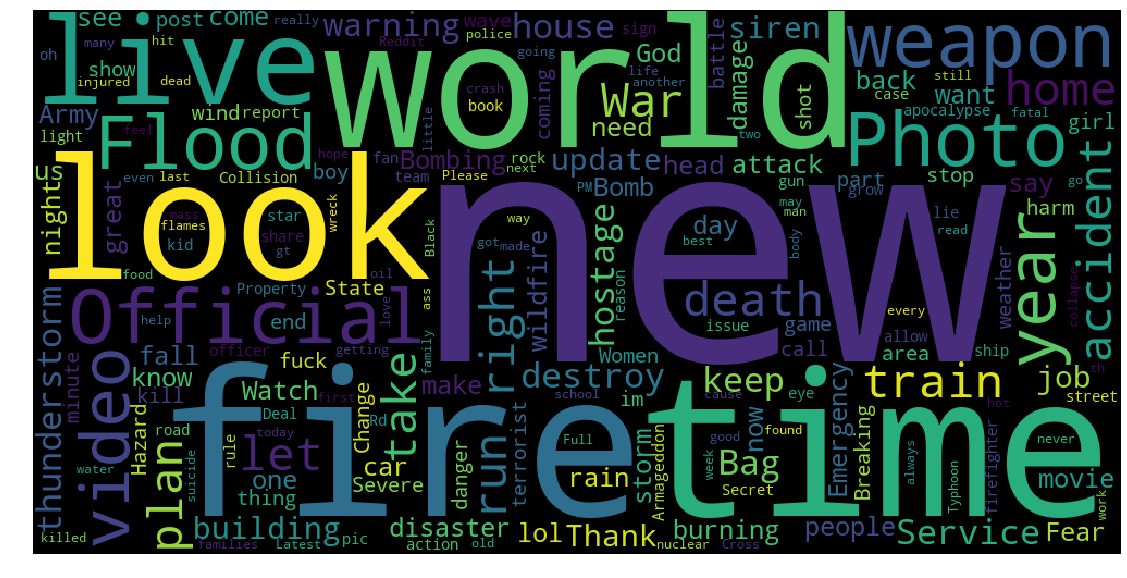

In [27]:
### Find popular words i.e words that occur regularly in key_list2
total_text2 = (' '.join(key_list2))

wordcloud2 = WordCloud(width=1000, height=500, stopwords=stop_words3).generate(total_text2)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud2)
plt.axis('off') #to remove the axis number from showing

## VECTORIZE THE COLUMN

In [28]:
count_vectorizer = feature_extraction.text.TfidfVectorizer(stop_words = stop_words3)
example_train_vectors = count_vectorizer.fit_transform(hope['text'][0:5])

In [29]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 37)
[[0.         0.         0.         0.37796447 0.         0.
  0.         0.37796447 0.37796447 0.         0.         0.
  0.         0.37796447 0.         0.         0.37796447 0.
  0.         0.         0.         0.         0.         0.
  0.         0.37796447 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.37796447
  0.        ]]


In [30]:
example_train_vectors

<5x37 sparse matrix of type '<class 'numpy.float64'>'
	with 40 stored elements in Compressed Sparse Row format>

The above tells us that:
1. There are 37 unique words (or "tokens") in the first five tweets.
2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

Now let's create vectors for all of our tweets.

In [31]:
#Create vectors from your training data
train_vectors = count_vectorizer.fit_transform(hope['text'])

In [32]:
## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])

### Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a _linear_ connection. So let's build a linear model and see!

In [33]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

Let's test our model and see how well it does on the training data. For this we'll use `cross-validation` - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [34]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59762309, 0.55442359, 0.65580662])

The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - give any of them a shot!

In the meantime, let's do predictions on our training set and build a submission for the competition.

In [35]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [36]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [37]:
sample_submission["target"] = clf.predict(test_vectors)

In [38]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [39]:
sample_submission.to_csv("submission.csv", index=False)

Now, in the viewer, you can submit the above file to the competition! Good luck!